All libraries can be installed with pip besides prophet. Install using conda install -c conda-forge fbprophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn
from plotnine import aes, ggplot
import pathlib
from datetime import datetime
import xlrd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

Importing plotly failed. Interactive plots will not work.


# Import Datasets

All CPI data was downloaded from https://www.statssa.gov.za/?page_id=1854&PPN=P0141

In [2]:
# get directory path
path = str(pathlib.Path().cwd().parent.parent.resolve())

In [3]:
# load raw data from stastsa
raw_df = pd.read_excel(
    path + "/data/EXCEL - CPI(5 and 8 digit) from Jan 2017 (202305).xlsx",
    dtype="object",
)

There are 12 main categories that are used to calculate the Headline CPI. Each category has a number of sub categories. This data set contains the CPI on sub-category level.

Create a dataset where the CPI is calculated on the category level. These values will then be used in the models to predict the CPI for the different categories as well as the Headline CPI.

In terms of cleaning the data, I will do the following:
- Remove unnecessary columns.
- Change column headers to make them more explanatory.
- Replace all `..` entries with a `0`. There are products which were included in the CPI calculations at a later stage and some products that were removed from the CPI calculation. Categories with no value at the time has a `..`, I will replace them with a `0`. The type of the column can then be updated to float.
- Combine the `Super maize` and `Special maize` categories into a single `Maize meal` category, to correspond with the current use of maize meal.
- Create a function to calculate the CPI values for each month using the weights provided in the file.


In [4]:
def get_montly_cpi(raw_df):
    """Function that takes the raw cpi data for each product from statssa and calculates the cpi value per category

    Arguments:
    ----------
    raw_df: pandas dataframe
            dataframe containing raw data from statsa

    Return:
    -------
    df_cpi: pandas dataframe
            dataframe containing the monthly cpi per category
    """

    # 1. remove unecessary columns and rename
    list_cols_to_drop = ["H01", "H02", "H05", "H06", "H07"]
    cat_cpi_df = raw_df.copy().drop(list_cols_to_drop, axis=1).copy()

    cat_cpi_df.rename(
        columns={
            "H03": "category_codes",
            "H04": "category_descr",
            "Weight (All urban)": "weights_urban",
        },
        inplace=True,
    )

    # 2. replace .. with zeros
    cat_cpi_df.replace("..", 0, inplace=True)

    # 3. combine maize meal categories
    cat_cpi_df.iloc[17:19] = (
        cat_cpi_df.iloc[17:19].copy().apply(pd.to_numeric, errors="coerce")
    )
    divided_row = (cat_cpi_df.iloc[17].copy() + cat_cpi_df.iloc[18].copy()) / 2
    cat_cpi_df.iloc[15] = [
        divided_row[i] if value == 0 else value
        for i, value in enumerate(cat_cpi_df.iloc[15].copy())
    ]
    cat_cpi_df.drop([cat_cpi_df.index[17], cat_cpi_df.index[18]], inplace=True)

    # Convert the 'weights_urban' column to float
    cat_cpi_df["weights_urban"] = cat_cpi_df["weights_urban"].astype("float")

    # 4. calculate cpi
    # Assign a main category code to each raw data row.
    main_category = []
    for index, row in cat_cpi_df.iterrows():
        if (len(row["category_codes"]) == 8) & (
            row["category_codes"][:2] in ["01", "02"]
        ):
            main_category.append(row["category_codes"][:2])
        elif (
            len(row["category_codes"]) == 5
        ):  # & (row['category_codes'][:2] not in ["04","07"]):
            main_category.append(row["category_codes"][:2])
        else:
            main_category.append("no")

    cat_cpi_df["main_category_code"] = main_category

    # Drop the rows where the main_category_code is "no". That is to prevent double counting.
    # Some categories have a sub category included in the data.
    cat_cpi_df.drop(
        cat_cpi_df[cat_cpi_df["main_category_code"] == "no"].index, inplace=True
    )

    # Sum the weights for each category
    sum_weights = cat_cpi_df.groupby("main_category_code")["weights_urban"].sum()

    # create new cpi dataframe
    cpi_df = pd.DataFrame()

    # For each month create the headline CPI value and the CPI value per category.
    for col in range(3, cat_cpi_df.shape[1] - 1):
        cat_cpi_df = cat_cpi_df.copy()
        column_name = cat_cpi_df.columns[col]
        cat_cpi_df["weighted_index_" + column_name] = (
            cat_cpi_df["weights_urban"] * cat_cpi_df[column_name]
        )

        sum_weighted_index = cat_cpi_df.groupby("main_category_code")[
            "weighted_index_" + column_name
        ].sum()

        # Concatenate the DataFrames horizontally
        concat_df = pd.concat([sum_weights, sum_weighted_index], axis=1)

        # Add a row that sums the values in the columns
        sums_df = pd.DataFrame(
            concat_df.sum().values.reshape(1, -1), columns=concat_df.columns
        )
        sums_df = sums_df.set_index(pd.Index(["headline"]))

        # Concatenate the headline dataframe to the categories
        month_cpi_df = pd.concat([concat_df, sums_df], axis=0)

        # Calculate the CPI value
        month_cpi_df["cpi_" + column_name] = (
            month_cpi_df["weighted_index_" + column_name]
            / month_cpi_df["weights_urban"]
        ).round(1)

        cpi_df = pd.concat(
            [cpi_df, month_cpi_df[["weights_urban", "cpi_" + column_name]]], axis=1
        )

    # Remove duplicate weights columns and reset the index
    cpi_df = cpi_df.loc[:, ~cpi_df.columns.duplicated()]
    cpi_df = cpi_df.reset_index().rename(columns={"index": "category"})

    # Dataframe with just the CPI values:
    cpi_df = cpi_df.drop("weights_urban", axis=1).copy()
    transposed_cpi_df = cpi_df.set_index("category").transpose().reset_index()
    transposed_cpi_df["date"] = transposed_cpi_df["index"].apply(
        lambda x: x.split("M")[-1]
    )
    transposed_cpi_df["date"] = transposed_cpi_df["date"].apply(
        lambda x: x[:4] + "-" + x[-2:]
    )
    # change month to datetime format
    transposed_cpi_df["date"] = pd.to_datetime(transposed_cpi_df["date"]).dt.strftime(
        "%Y-%m"
    )

    return transposed_cpi_df

In [5]:
cpi = get_montly_cpi(raw_df=raw_df)

In [6]:
# Create a category dictionary with the category code and description
category_dict = {
    "01": "Food and non-alcoholic beverages",
    "02": "Alcoholic beverages and tobacco",
    "03": "Clothing and footwear",
    "04": "Housing and utilities",
    "05": "Household contents and services",
    "06": "Health",
    "07": "Transport",
    "08": "Communication",
    "09": "Recreation and culture",
    "10": "Education",
    "11": "Restaurants and hotels",
    "12": "Miscellaneous goods and services",
    "headline": "headline CPI",
}

In [7]:
def plot_montly_cpi(cpi_df, cat_dict):
    """Plots monthly cpi

    Arguments:
    ----------
    cpi_df: pandas dataframe
            monthly cpi of each category

    cat_dict: dict
            dictionary mapping category numbers to category names
    """

    ax = cpi_df.plot.line(linewidth=1, figsize=(20, 10))  # Set the default linewidth
    ax.lines[12].set_linewidth(3)

    # Modify the legend labels
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [category_dict.get(label, label) for label in labels]
    plt.legend(handles, new_labels)

    # Adding labels and title
    plt.xlabel("Month")
    plt.ylabel("CPI")
    plt.title("Headline and Category CPI Values from 2017 to 2023")

    # Displaying the graph
    plt.show()

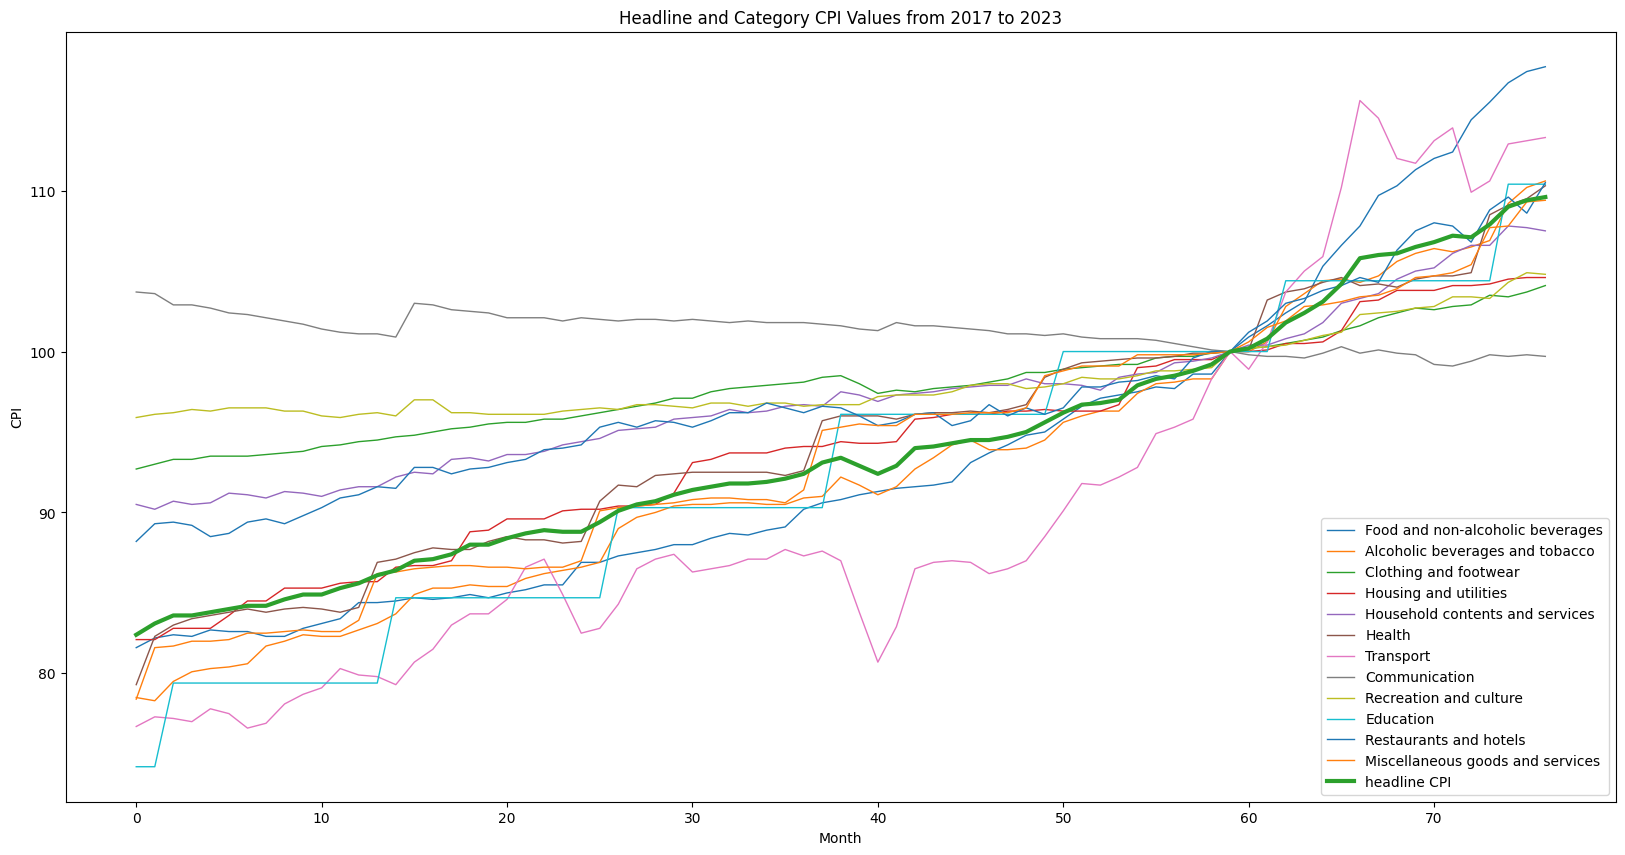

In [8]:
plot_montly_cpi(cpi_df=cpi, cat_dict=category_dict)

In [9]:
monthly_cpi_df = cpi.copy()
monthly_cpi_df.reset_index(inplace=True)
monthly_cpi_df.rename(columns={"index": "year_month"}, inplace=True)
monthly_cpi_df["year_month"] = monthly_cpi_df["year_month"].str[5:]
monthly_cpi_df["year_month"] = pd.to_datetime(
    monthly_cpi_df["year_month"], format="%Y%m"
)
monthly_cpi_df = monthly_cpi_df.drop(["level_0", "date"], axis=1)

In [10]:
cpi.head()

category,index,01,02,03,04,05,06,07,08,09,10,11,12,headline,date
0,cpi_M201701,81.6,78.5,92.7,82.1,90.5,79.3,76.7,103.7,95.9,74.2,88.2,78.4,82.4,2017-01
1,cpi_M201702,82.2,78.3,93.0,82.1,90.2,82.3,77.3,103.6,96.1,74.2,89.3,81.6,83.1,2017-02
2,cpi_M201703,82.4,79.5,93.3,82.8,90.7,83.0,77.2,102.9,96.2,79.4,89.4,81.7,83.6,2017-03
3,cpi_M201704,82.3,80.1,93.3,82.8,90.5,83.4,77.0,102.9,96.4,79.4,89.2,82.0,83.6,2017-04
4,cpi_M201705,82.7,80.3,93.5,82.8,90.6,83.6,77.8,102.7,96.3,79.4,88.5,82.0,83.8,2017-05


## Holt Winters model

A different historic data range is used for each category

In [11]:
def predict_cpi_with_holt_winters(df, nr_months_ahead):
    """Function that fits a holtwinters model and makes a prediction

    Arguments:
    ----------
    df: pandas dataframe
        dataframe containing historic cpi information
    nr_months_ahead: int
                     number of months to make forecast

    Return:
    -------
    cpi_dict: dict
              dictionary for category name as key and date and predicted cpi as value
    """
    column_names = df.columns[1:]

    # Iterate through the selected categories
    for column_name in column_names:
        column_data = df[column_name]

        cat_df = df[["year_month", column_name]]

        # Set the random seed
        np.random.seed(111)

        # Create the date for new forecasted value
        pred_date = cat_df["year_month"].iloc[-1:] + pd.DateOffset(
            months=nr_months_ahead
        )
        pred_year_month = np.datetime_as_string(pred_date, unit="D")[0]

        # Forecast new value(s) using the full data set to train
        model_holt_winters = ExponentialSmoothing(
            cat_df[column_name], trend="mul", seasonal="mul", seasonal_periods=12
        ).fit(optimized=True)
        pred_cpi_holt_winters = model_holt_winters.forecast(2).values[
            nr_months_ahead - 1
        ]

        # Add prediction to CPI dictionary
        cpi_dict = {}
        cpi_dict[column_name] = [pred_year_month, pred_cpi_holt_winters]

        return cpi_dict

In [12]:
cat1_cpi = monthly_cpi_df.iloc[:, 0:2]
reduced_cat1_cpi = cat1_cpi.drop(index=cat1_cpi.index[:36]).copy()
cat1_predict = predict_cpi_with_holt_winters(reduced_cat1_cpi, nr_months_ahead=1)

In [13]:
cat2_cpi = monthly_cpi_df[["year_month", "02"]]
reduced_cat2_cpi = cat2_cpi.drop(index=cat2_cpi.index[:48]).copy()
cat2_predict = predict_cpi_with_holt_winters(reduced_cat2_cpi, nr_months_ahead=1)

In [14]:
cat3_cpi = monthly_cpi_df[["year_month", "03"]]
reduced_cat3_cpi = cat3_cpi.drop(index=cat3_cpi.index[:48]).copy()
cat3_predict = predict_cpi_with_holt_winters(reduced_cat3_cpi, nr_months_ahead=1)

In [15]:
cat4_cpi = monthly_cpi_df[["year_month", "04"]]
reduced_cat4_cpi = cat4_cpi.drop(index=cat4_cpi.index[:48]).copy()
cat4_predict = predict_cpi_with_holt_winters(reduced_cat4_cpi, nr_months_ahead=1)

In [16]:
cat5_cpi = monthly_cpi_df[["year_month", "05"]]
reduced_cat5_cpi = cat5_cpi.drop(index=cat5_cpi.index[:48]).copy()
cat5_predict = predict_cpi_with_holt_winters(reduced_cat5_cpi, nr_months_ahead=1)

In [17]:
cat6_cpi = monthly_cpi_df[["year_month", "06"]]
reduced_cat6_cpi = cat6_cpi.drop(index=cat6_cpi.index[:24]).copy()
cat6_predict = predict_cpi_with_holt_winters(reduced_cat6_cpi, nr_months_ahead=1)

In [18]:
cat7_cpi = monthly_cpi_df[["year_month", "07"]]
reduced_cat7_cpi = cat7_cpi.drop(index=cat7_cpi.index[:36]).copy()
cat7_predict = predict_cpi_with_holt_winters(reduced_cat7_cpi, nr_months_ahead=1)

In [19]:
cat8_cpi = monthly_cpi_df[["year_month", "08"]]
reduced_cat8_cpi = cat8_cpi.drop(index=cat8_cpi.index[:48]).copy()
cat8_predict = predict_cpi_with_holt_winters(reduced_cat8_cpi, nr_months_ahead=1)

In [20]:
cat9_cpi = monthly_cpi_df[["year_month", "09"]]
reduced_cat9_cpi = cat9_cpi.drop(index=cat9_cpi.index[:24]).copy()
cat9_predict = predict_cpi_with_holt_winters(reduced_cat9_cpi, nr_months_ahead=1)

/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul


In [21]:
cat10_cpi = monthly_cpi_df[["year_month", "10"]]
reduced_cat10_cpi = cat10_cpi.drop(index=cat10_cpi.index[:36]).copy()
cat10_predict = predict_cpi_with_holt_winters(reduced_cat10_cpi, nr_months_ahead=1)

In [22]:
cat11_cpi = monthly_cpi_df[["year_month", "11"]]
reduced_cat11_cpi = cat11_cpi.drop(index=cat11_cpi.index[:48]).copy()
cat11_predict = predict_cpi_with_holt_winters(reduced_cat11_cpi, nr_months_ahead=1)

In [23]:
cat12_cpi = monthly_cpi_df[["year_month", "12"]]
reduced_cat12_cpi = cat12_cpi.drop(index=cat12_cpi.index[:24]).copy()
cat12_predict = predict_cpi_with_holt_winters(reduced_cat12_cpi, nr_months_ahead=1)

In [24]:
headline_cpi = monthly_cpi_df[["year_month", "headline"]]
reduced_headline_cpi = headline_cpi.drop(index=headline_cpi.index[:48]).copy()
headline_predict = predict_cpi_with_holt_winters(
    reduced_headline_cpi, nr_months_ahead=1
)

In [29]:
cpi_dict = {}
for d in [
    cat1_predict,
    cat2_predict,
    cat3_predict,
    cat4_predict,
    cat5_predict,
    cat6_predict,
    cat7_predict,
    cat8_predict,
    cat9_predict,
    cat10_predict,
    cat11_predict,
    cat12_predict,
    headline_predict,
]:
    cpi_dict.update(d)

In [30]:
prediction_df = (
    pd.DataFrame.from_dict(cpi_dict, orient="index", columns=["Year_Month", "Value"])
    .reset_index()
    .rename(columns={"index": "ID"})
)

In [31]:
prediction_df

,ID,Year_Month,Value
0,01,2023-06-01,118.295364
1,02,2023-06-01,110.667741
2,03,2023-06-01,104.365372
3,04,2023-06-01,105.193152
4,05,2023-06-01,108.619856
5,06,2023-06-01,110.313703
6,07,2023-06-01,116.242440
7,08,2023-06-01,99.911807
8,09,2023-06-01,105.083106
9,10,2023-06-01,110.399980


# Get submission file

In [33]:
pred_month = pd.to_datetime(prediction_df["Year_Month"].unique()[0]).strftime("%B")

# drop the month from the dataframe
prediction_df.drop(["Year_Month"], axis=1, inplace=True)

In [34]:
pred_category_dict = {
    "01": pred_month + "_food and non-alcoholic beverages",
    "02": pred_month + "_alcoholic beverages and tobacco",
    "03": pred_month + "_clothing and footwear",
    "04": pred_month + "_housing and utilities",
    "05": pred_month + "_household contents and services",
    "06": pred_month + "_health",
    "07": pred_month + "_transport",
    "08": pred_month + "_communication",
    "09": pred_month + "_recreation and culture",
    "10": pred_month + "_education",
    "11": pred_month + "_restaurants and hotels",
    "12": pred_month + "_miscellaneous goods and services",
    "headline": pred_month + "_headline CPI",
}

In [38]:
prediction_df = prediction_df.replace(pred_category_dict)

In [37]:
prediction_df.to_csv(path + "/submissions/v15_HW.csv", index=False)